<a href="https://colab.research.google.com/github/lasithadilshan/Chest_XRay_Pneumonia_Project/blob/master/Pneumonia_Classification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install required packages**

In [ ]:
!pip install kaggle matplotlib seaborn tensorflow keras scikit-learn

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Upload Kagalle Json File

In [ ]:
from google.colab import files

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dilshan2024","key":"73aae8283209ff050a3c80f8a3d4267d"}'}

# Prompt for user input

In [ ]:
try:
    files.upload()  # This will prompt you to upload the kaggle.json file
except Exception as e:
    print(f"Error uploading file: {e}")

Saving kaggle.json to kaggle.json


# Configure Kaggle Credentials - Create a directory for the Kaggle API key and move the file there

In [ ]:
import os

try:
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json  # Change the file permissions
except Exception as e:
    print(f"Error configuring Kaggle credentials: {e}")

# Download the Dataset from Kaggle

In [ ]:
%cd /content/drive/MyDrive/kaggle_datasets
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

/content/drive/MyDrive/kaggle_datasets
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:30<00:00, 43.2MB/s]
100% 2.29G/2.29G [00:30<00:00, 79.7MB/s]


# Extract the *Dataset*

In [ ]:
!unzip /content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia.zip -d /content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-

# Importing necessary libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define paths for training, testing, and validation data

In [ ]:
train_data_dir = '/content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/train'
test_data_dir = '/content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/test'
val_data_dir = '/content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/val'

# Display some example images

In [ ]:
def plot_images(images, labels):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes = axes.flatten()
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img, cmap='gray')
        ax.set_title(label)
    plt.tight_layout()
    plt.show()

# Load a few sample images from each class

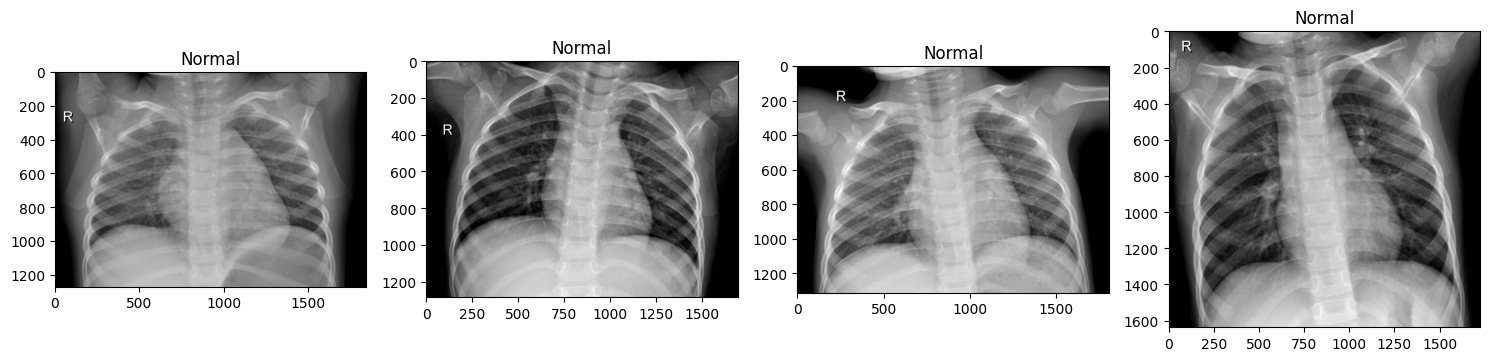

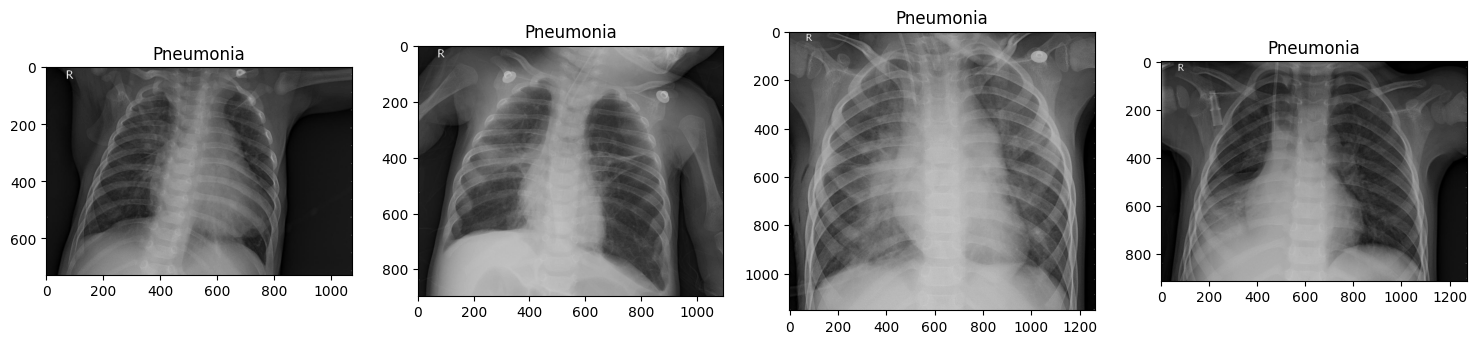

In [73]:
try:
    sample_normal = [plt.imread(os.path.join(train_path, 'NORMAL', img)) for img in os.listdir(os.path.join(train_path, 'NORMAL'))[:4]]
    sample_pneumonia = [plt.imread(os.path.join(train_path, 'PNEUMONIA', img)) for img in os.listdir(os.path.join(train_path, 'PNEUMONIA'))[:4]]

    plot_images(sample_normal, ['Normal'] * 4)
    plot_images(sample_pneumonia, ['Pneumonia'] * 4)
except Exception as e:
    print(f"Error loading sample images: {e}")

# Data Preprocessing - Image preprocessing and augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Loading the images

In [ ]:
try:
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary'
    )

    validation_generator = test_datagen.flow_from_directory(
        val_path,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary'
    )

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary',
        shuffle=False
    )
except Exception as e:
    print(f"Error in data loading: {e}")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


> # Create the Model

# Build the CNN model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile the model

In [72]:
try:
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
except Exception as e:
    print(f"Error in model compilation: {e}")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [ ]:
try:
    # Set target size for the images
    target_size = (128, 128)

    epochs = 10  # Adjust if needed
    batch_size = 8

    steps_per_epoch = train_generator.samples // batch_size
    validation_steps = max(1, validation_generator.samples // batch_size)

    print(f"Number of validation samples: {validation_generator.samples}")
    print(f"Classes: {validation_generator.class_indices}")

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1
    )
except Exception as e:
    print(f"Error during model training: {e}")

Number of validation samples: 16
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/652 ━━━━━━━━━━━━━━━━━━━━ 11:32 1s/step - accuracy: 0.7627 - loss: 0.5225

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


652/652 ━━━━━━━━━━━━━━━━━━━━ 238s 354ms/step - accuracy: 0.8062 - loss: 0.4414 - val_accuracy: 0.8125 - val_loss: 0.4327
Epoch 2/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 251s 337ms/step - accuracy: 0.8883 - loss: 0.2723 - val_accuracy: 0.6875 - val_loss: 0.6337
Epoch 3/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 224s 337ms/step - accuracy: 0.8958 - loss: 0.2528 - val_accuracy: 0.5625 - val_loss: 0.8960
Epoch 4/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 230s 346ms/step - accuracy: 0.9169 - loss: 0.2154 - val_accuracy: 0.7500 - val_loss: 0.6110
Epoch 5/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 223s 336ms/step - accuracy: 0.9281 - loss: 0.1834 - val_accuracy: 0.6875 - val_loss: 0.7154
Epoch 6/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 269s 347ms/step - accuracy: 0.9339 - loss: 0.1670 - val_accuracy: 0.6250 - val_loss: 0.9062
Epoch 7/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 224s 338ms/step - accuracy: 0.9366 - loss: 0.1741 - val_accuracy: 0.6875 - val_loss: 0.8527
Epoch 8/10
652/652 ━━━━━━━━━━━━━━━━━━━━ 225s 338ms/step - accuracy: 0.9388 - loss: 0.17

# Evaluate the Model

> ## Evaluate the model on the validation dataset

In [ ]:
loss, accuracy = model.evaluate(validation_generator, steps=validation_steps)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6875 - loss: 0.7554 
Validation Loss: 0.7554
Validation Accuracy: 0.6875


> ## Generate predictions

In [65]:
import numpy as np

# Get a batch of validation data
x_val, y_val = next(validation_generator)

# Predict the classes of the validation batch
predictions = model.predict(x_val)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Print actual vs predicted classes
for i in range(len(y_val)):
    print(f"Actual: {y_val[i]}, Predicted: {predicted_classes[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Actual: 1.0, Predicted: 0
Actual: 0.0, Predicted: 0
Actual: 1.0, Predicted: 0
Actual: 1.0, Predicted: 0
Actual: 1.0, Predicted: 0
Actual: 0.0, Predicted: 0
Actual: 1.0, Predicted: 0
Actual: 0.0, Predicted: 0
Actual: 0.0, Predicted: 0
Actual: 0.0, Predicted: 0
Actual: 0.0, Predicted: 0
Actual: 1.0, Predicted: 0
Actual: 1.0, Predicted: 0
Actual: 0.0, Predicted: 0
Actual: 1.0, Predicted: 0
Actual: 0.0, Predicted: 0


In [75]:
from keras.preprocessing import image
import numpy as np
from PIL import Image

In [76]:
def load_and_preprocess_image(img_path):
    img = Image.open(img_path)  # Load the image
    img = img.resize((128, 128))  # Resize to match model input
    img_array = np.array(img) / 255.0  # Normalize the image array
    # Check if image has three channels (RGB)
    if img_array.ndim == 2:  # If grayscale, convert to RGB
        img_array = np.stack((img_array,) * 3, axis=-1)
    elif img_array.shape[2] == 4:  # If RGBA, remove alpha channel
        img_array = img_array[:, :, :3]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

In [82]:
# Example path to your test image
test_image_path = '/content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1_virus_6.jpeg'  # Update this with the actual path
processed_image = load_and_preprocess_image(test_image_path)

In [83]:
# Print the shape of the processed image for debugging
print(f"Processed image shape: {processed_image.shape}")

Processed image shape: (1, 128, 128, 3)


In [84]:
# Make predictions on the test image
predictions = model.predict(processed_image)
predicted_class = np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [86]:
# Map the predicted class index to class label
class_labels = {0: 'NORMAL', 1: 'PNEUMONIA'}  # Update based on your class mapping
predicted_label = class_labels[predicted_class[0]]

In [87]:
# Print the predicted class
print(f"Predicted Class: {predicted_label}")

Predicted Class: NORMAL


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 624ms/step - accuracy: 0.8620 - loss: 0.5229
Test Accuracy: 90.06%


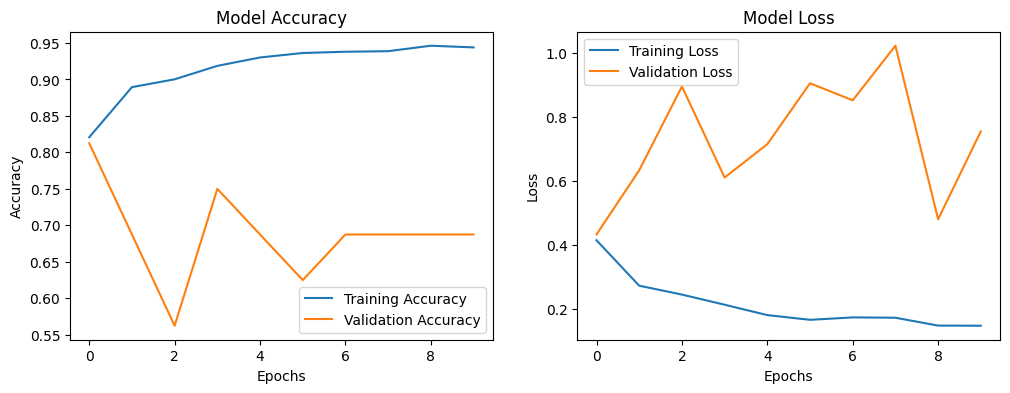

In [88]:
# Evaluate the model performance on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Plot the loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 725ms/step
Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.95      0.78      0.85       234
   PNEUMONIA       0.88      0.97      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.91      0.90      0.90       624



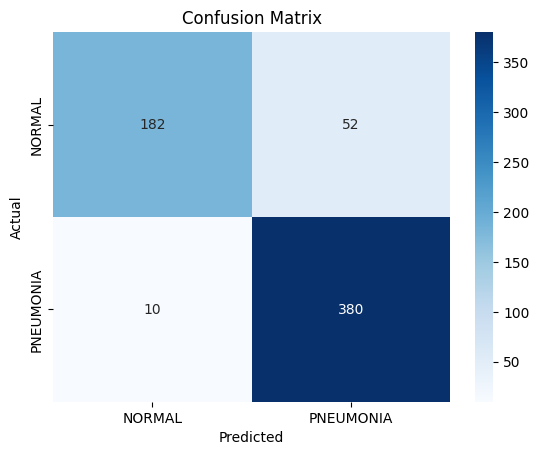

In [89]:
# Predicting the classes for the test data
predictions = model.predict(test_generator)
predicted_classes = [1 if pred > 0.5 else 0 for pred in predictions]

# Confusion Matrix and Classification Report
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [90]:
model.save('pneumonia_detection_model.h5')

In [91]:
model.save('my_model.keras')